In [1]:
%run stdPackages.ipynb

# Social Security Design - Argentina

This loops through different parameter values for $\rho$, calibrates the model, stores the dictionary of policy functions for each $t$, stores main calibration parameters, and the solution path. We start from the LOG model.

In [2]:
t0date = 2010
ngrid = 50
ns0 = 25
t_ss  = 5 # number of periods in steady state
%run ArgentinaData.ipynb

### Analytical PEE Model

In [3]:
kwargs = {k: kwargs[k] for k in ('T', 'nj','ngrid')}
gridkwargs = {'τ_n': 251}
m = argentina_main.Model_A(pars = targs | pars | parsj, gridkwargs = gridkwargs, **kwargs)
m.db.update(m.adjPar('ρ', 1.05))

Solve with standard gradient based methods:

In [4]:
sols = m.PEE()

Solve with gridsearch:

In [5]:
# m.PEE.kwargs_T['style'] = 'GridSC'
# m.PEE.kwargs_T_['style'] = 'GridSC'
# m.PEE.kwargs_t['style'] = 'GridSC'
# m.PEE.kwargsMain = m.defaultKwargs
# solsGrid = m.PEE()

Solve for economic equilibrium given sequence of policy functions:

In [6]:
path = m.EE_FH_PEE_solve(sols)

Try the "robust solve" that starts by approximating the equilibrium, then solving:

In [7]:
pathRbst = m.EE_FH_PEE_solveRobust(sols)

### Log model

Solve log-model with gradient based optimization, approximate grid search (assumes steady state), and grid search:

In [8]:
logSol = m.LOG.solve(style = 'Vector')
logSolApprox = m.LOG.solve(style = 'ApproxGridSC', update = False)
logSolGrid = m.LOG.solve(style = 'GridSC')
logRobust = m.LOG.solve(style = 'Robust') # solve first with gridsearch, then gradient based methods

Log path:

In [9]:
pathLog = m.EE_FH_LOG_solve(logSol['τ'])

### Compare LOG-model with CRRA

<Axes: xlabel='t'>

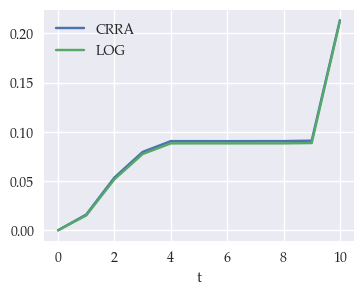

In [10]:
pd.DataFrame({'CRRA': path['τ'], 'LOG': logSol['τ']}).plot(figsize=(4,3))

### Calibrate Models

In [11]:
ρLower = np.round(np.linspace(0.75, 1, 11), 3) # we need more dense grid when we lower ρ 
ρUpper = np.round(np.linspace(1, 2, 11), 3)
# ρgrid = np.array([1, 1.1])
ρgrid = np.hstack([ρLower, ρUpper[1:]])
sols = dict.fromkeys(ρgrid)
cals = dict.fromkeys(ρgrid)
paths = dict.fromkeys(ρgrid)

Test other stuff:

In [12]:
cals[1] = m.calibLOG()
paths[1], sols[1] = m.solvePEE()

Ignore ```RunTimeWarning``` in the following:

In [13]:
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

Switch up some kwargs here:

In [14]:
m.PEE.kwargs_t['style'] = 'VeryRobust'
m.PEE.kwargs_t['x0_from_solp'] = False
m.PEE.kwargs_T_['style'] = 'VeryRobust'
m.PEE.kwargs_T['style'] = 'VeryRobust'
m.PEE.kwargsMain = m.PEE.defaultKwargs

Loop through $\rho$:

In [15]:
def simpleρIte(ρgrid):
    for ρ in ρgrid:
        try:
            m.db.update(m.adjPar('ρ',ρ))
            cals[ρ] = m.calibPEE(method = 'hybr', tol = 1e-5)
            paths[ρ], sols[ρ] = m.solvePEE()
            # sols[ρ] = m.PEE.FH()
            # paths[ρ] = m.EE_FH_PEE_solve(sols[ρ])
        except AssertionError:
            cals[ρ] = """Failed to calibrate"""
        print(ρ)

Loop through parameter values and resolve:

In [16]:
simpleρIte(ρgrid[ρgrid>1]) # solve for ρ > 1
m.calibUpdateParameters(cals[1]) # reset to log
m.PEE.interpInitialsFromLOG(sols[1])
simpleρIte(ρgrid[ρgrid<1][::-1]) # solve for ρ < 1

1.1
1.2
1.3


KeyboardInterrupt: 